# Symbolic Fuzzing

One of the problems with traditional methods of fuzzing is that they fail to exercise all the possible behaviors that a system can have, especially when the input space is large. Quite often the execution of a specific branch of execution may happen only with very specific inputs, which could represent an extremely small fraction of the input space. The traditional fuzzing methods relies on chance to produce inputs they need. However, relying on randomness to generate values that we want is a bad idea when the space to be explored is huge. For example, a function that accepts a string, even if one only considers the first $10$ characters, already has $2^{80}$ possible inputs. If one is looking for a specific string, random generation of values will take a few thousand years even in one of the super computers.

We saw previously how concolic tracing can offer a way out. We saw how concolic tracing can be implemented using direct information flows using the Python interpreter. However, there are two problems with this approach. The first is that, concolic tracing relies on the existence of sample inputs. What if one has no sample inputs? Secondly, direct information flows could be unreliable if the program has indirect information flows such as those based on control flow. In such cases, static analysis becomes necessary to bridge the gap. However, that raises the question. Can we determine the complete behavior of the program by examining it statically, and check if it behaves unexpectedly under some (unknown) input or result in an unexpected output?

Symbolic execution is one of the ways that we can reason about the behavior of a program without executing it. A program is a computation that can be treated as a system of equations that obtains the output values from the given inputs. Executing the program symbolically -- that is, solving these mathematically -- along with any specified objective such as covering a particular branch or obtaining a particular output will get us inputs that can accomplish this task.

In this chapter, we investigate how symbolic execution can be implemented, and how it can be used to obtain interesting values for fuzzing.

**Prerequisites**

* You should understand how to use [type annotations](https://docs.python.org/3/library/typing.html) in Python.
* A working knowledge of [SMT solvers](https://en.wikipedia.org/wiki/Satisfiability_modulo_theories), especially [Z3](https://github.com/Z3Prover/z3) is useful.
* You should have read the [chapter on coverage](Coverage.ipynb).
* A familiarity with [chapter on concolic fuzzing](ConcolicFuzzer.ipynb) would be helpful.

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from fuzzingbook.SymbolicFuzzer import <identifier>
```

and then make use of the following features.


This chapter provides an implementation of a symbolic fuzzing engine `AdvancedSymbolicFuzzer`. The fuzzer uses symbolic execution to exhaustively explore paths in the program to a limited depth, and generate inputs that will reach these paths. Given a program to explore (`gcd` here), the fuzzer can be used as follows:

```python
>>> gcd_fuzzer = AdvancedSymbolicFuzzer(gcd, max_tries=10, max_iter=10, max_depth=10)
>>> for i in range(10):
>>>     r = gcd_fuzzer.fuzz()
>>>     print(r)
{'a': 7, 'b': 5}
{'a': -1, 'b': 0}
{'a': 2, 'b': 7}
{'a': 10, 'b': 9}
{'a': 11, 'b': 21}
{'a': 11, 'b': -11}
{'a': 7, 'b': 6}
{'a': -2, 'b': 0}
{'a': 12, 'b': -12}
{'a': 9, 'b': 2}
```


## Obtaining Path Conditions for Coverage

In the chapter on [parsing and recombining inputs](SearchBasedFuzzer.ipynb), we saw how difficult it was to generate inputs for `process_vehicle()` -- a simple function that accepts a string. The solution given there was to rely on preexisting sample inputs. However, this solution is inadequate as it assumes the existence of sample inputs. What if there are no sample inputs at hand?

For a simpler example, let us consider the following function. Can we generate inputs to cover all the paths?

*Note.* We use type annotations to denote the argument types of programs. The [chapter on discovering dynamic invariants](DynamicInvariants.ipynb) will discuss how these types can be inferred automatically.

In [1]:
def check_triangle(a: int, b: int, c: int) -> int:
    if a == b:
        if a == c:
            if b == c:
                return "Equilateral"
            else:
                return "Isosceles"
        else:
            return "Isosceles"
    else:
        if b != c:
            if a == c:
                return "Isosceles"
            else:
                return "Scalene"
        else:
            return "Isosceles"

### The Control Flow Graph

The control flow graph of this function can be represented as follows:

In [2]:
import bookutils

In [3]:
from ControlFlow import PyCFG, CFGNode, to_graph, gen_cfg

In [4]:
import inspect

In [5]:
from graphviz import Source, Graph

In [6]:
def show_cfg(fn, **kwargs):
    return Source(to_graph(gen_cfg(inspect.getsource(fn)), **kwargs))

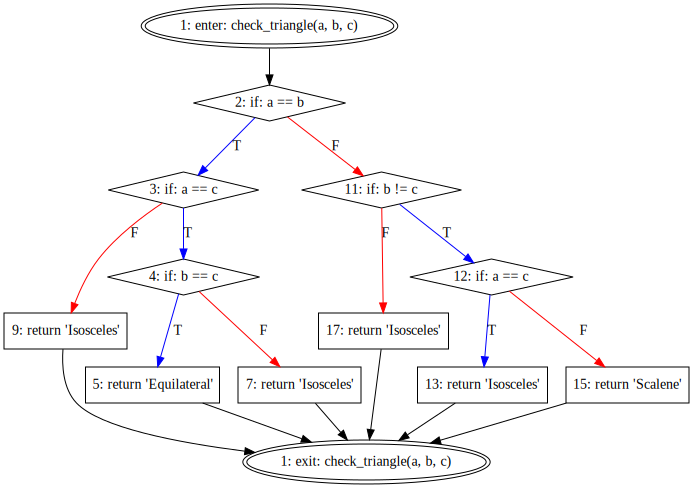

In [7]:
show_cfg(check_triangle)

The possible execution paths traced by the program can be represented as follows, with the numbers indicating the specific line numbers executed.

In [8]:
paths = {
    '<path 1>': ([1, 2, 3, 4, 5], 'Equilateral'),
    '<path 2>': ([1, 2, 3, 4, 7], 'Isosceles'),
    '<path 3>': ([1, 2, 3, 9], 'Isosceles'),
    '<path 4>': ([1, 2, 11, 12, 13], 'Isosceles'),
    '<path 5>': ([1, 2, 11, 12, 15], 'Scalene'),
    '<path 6>': ([1, 2, 11, 17], 'Isosceles'),
}

Consider the `<path 1>`. To trace this path, we need to execute the following statements in order.

```python
1: check_triangle(a, b, c)
2: if (a == b) -> True
3: if (a == c) -> True
4: if (b == c) -> True
5: return 'Equilateral'
```

That is, any execution that traces this path has to start with values for `a`, `b`, and `c` that obeys the constraints in line numbers `2: (a == b)` evaluates to `True`, `3: (a == c)` evaluates to `True`, and `4: (b == c)` evaluates to `True`. Can we generate inputs such that these constraints are satisfied?

We have seen from the [chapter on concolic fuzzing](ConcolicFuzzer.ipynb) how one can use an SMT solver such as Z3 to obtain a solution.

In [9]:
import z3

What kind of symbolic variables do we need? We can obtain that information from the type annotations of the function.

In [10]:
def get_annotations(fn):
    sig = inspect.signature(fn)
    return ([(i.name, i.annotation)
             for i in sig.parameters.values()], sig.return_annotation)

In [11]:
params, ret = get_annotations(check_triangle)
params, ret

([('a', int), ('b', int), ('c', int)], int)

We create symbolic variables to represent each of the parameters

In [12]:
SYM_VARS = {
    int: (
        z3.Int, z3.IntVal), float: (
            z3.Real, z3.RealVal), str: (
                z3.String, z3.StringVal)}

In [13]:
def get_symbolicparams(fn):
    params, ret = get_annotations(fn)
    return [SYM_VARS[typ][0](name)
            for name, typ in params], SYM_VARS[ret][0]('__return__')

In [14]:
(a, b, c), r = get_symbolicparams(check_triangle)
a, b, c, r

(a, b, c, __return__)

We can now ask *z3* to solve the set of equations for us as follows.

In [15]:
z3.solve(a == b, a == c, b == c)

[a = 0, b = 0, c = 0]


Here we find the first problem in our program. Our program seems to not check whether the sides are greater than zero. Assume for now that we do not have that restriction. Does our program correctly follow the path described?

We can use the `ArcCoverage` from the [chapter on concolic fuzzing](ConcolicFuzzer.ipynb) as a tracer to visualize that information as below.

In [16]:
from ConcolicFuzzer import ArcCoverage  # minor dependency

First, we recover the trace.

In [17]:
with ArcCoverage() as cov:
    assert check_triangle(0, 0, 0) == 'Equilateral'
cov._trace, cov.arcs()

([('check_triangle', 1),
  ('check_triangle', 2),
  ('check_triangle', 3),
  ('check_triangle', 4),
  ('check_triangle', 5),
  ('__exit__', 79),
  ('__exit__', 80)],
 [(1, 2), (2, 3), (3, 4), (4, 5), (5, 79), (79, 80)])

We can now determine the path taken.

### The CFG with Path Taken

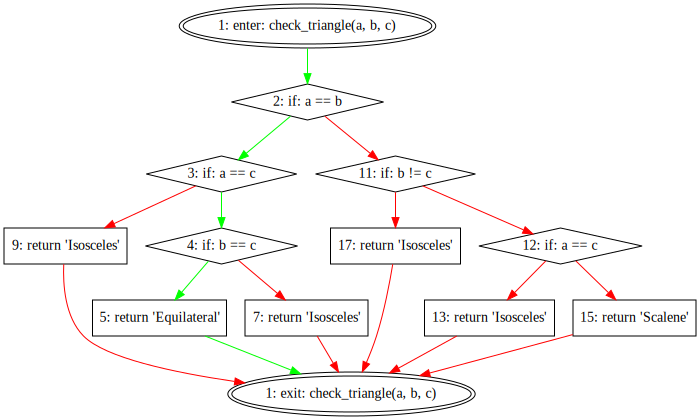

In [18]:
show_cfg(check_triangle, arcs=cov.arcs())

As you can see, the path taken is `<path 1>`.

Similarly, for solving `<path 2>` we need to simply invert the condition at <line 2>:

In [19]:
z3.solve(a == b, a == c, z3.Not(b == c))

no solution


The symbolic execution suggests that there is no solution. A moment's reflection will convince us that it is indeed true. Let us proceed with the other paths. The `<path 3>` can be obtained by inverting the condition at `<line 4>`.

In [20]:
z3.solve(a == b, z3.Not(a == c))

[c = 0, b = 1, a = 1]


In [21]:
with ArcCoverage() as cov:
    assert check_triangle(1, 1, 0) == 'Isosceles'
[i for fn, i in cov._trace if fn == 'check_triangle']

[1, 2, 3, 9]

In [22]:
paths['<path 3>']

([1, 2, 3, 9], 'Isosceles')

How about path <4>?

In [23]:
z3.solve(z3.Not(a == b), b != c, a == c)

[b = 0, c = 1, a = 1]


As we mentioned earlier, our program does not account for sides with zero or negative length. We can modify our program to check for zero and negative input. However, do we always have to make sure that every function has to account for all possible inputs? It is possible that the `check_triangle` is not directly exposed to the user, and it is called from another function that already guarantees that the inputs would be positive. In the [chapter on dynamic invariants](DynamicInvariants.ipynb), we will show how to discover such preconditions and post conditions.

We can easily add such a precondition here.

In [24]:
pre_condition = z3.And(a > 0, b > 0, c > 0)

In [25]:
z3.solve(pre_condition, z3.Not(a == b), b != c, a == c)

[c = 2, b = 1, a = 2]


In [26]:
with ArcCoverage() as cov:
    assert check_triangle(1, 2, 1) == 'Isosceles'
[i for fn, i in cov._trace if fn == 'check_triangle']

[1, 2, 11, 12, 13]

In [27]:
paths['<path 4>']

([1, 2, 11, 12, 13], 'Isosceles')

Continuing to path <5>:

In [28]:
z3.solve(pre_condition, z3.Not(a == b), b != c, z3.Not(a == c))

[b = 2, a = 1, c = 3]


And indeed it is a *Scalene* triangle.

In [29]:
with ArcCoverage() as cov:
    assert check_triangle(3, 1, 2) == 'Scalene'

In [30]:
paths['<path 5>']

([1, 2, 11, 12, 15], 'Scalene')

Finally, for `<path 6>` the procedure is similar.

In [31]:
z3.solve(pre_condition, z3.Not(a == b), z3.Not(b != c))

[c = 2, a = 1, b = 2]


In [32]:
with ArcCoverage() as cov:
    assert check_triangle(2, 1, 1) == 'Isosceles'
[i for fn, i in cov._trace if fn == 'check_triangle']

[1, 2, 11, 17]

In [33]:
paths['<path 6>']

([1, 2, 11, 17], 'Isosceles')

What if we wanted another solution? We can simply ask the solver to solve again, and not give us the same values.

In [34]:
seen = [z3.And(a == 2, b == 1, c == 1)]

In [35]:
z3.solve(pre_condition, z3.Not(z3.Or(seen)), z3.Not(a == b), z3.Not(b != c))

[c = 2, a = 1, b = 2]


In [36]:
seen.append(z3.And(a == 1, b == 2, c == 2))

In [37]:
z3.solve(pre_condition, z3.Not(z3.Or(seen)), z3.Not(a == b), z3.Not(b != c))

[c = 1, a = 3, b = 1]


That is, using simple symbolic computation, we were able to easily see that (1) some of the paths are not reachable, and (2) some of the conditions were insufficient -- we needed preconditions. What about the total coverage obtained?

### Visualizing the Coverage

Visualizing the statement coverage can be accomplished as below.

In [38]:
class ArcCoverage(ArcCoverage):
    def show_coverage(self, fn):
        src = fn if isinstance(fn, str) else inspect.getsource(fn)
        covered = set([lineno for method, lineno in self._trace])
        for i, s in enumerate(src.split('\n')):
            print('%s %2d: %s' % ('#' if i + 1 in covered else ' ', i + 1, s))

We run all the inputs obtained under the coverage tracer.

In [39]:
with ArcCoverage() as cov:
    assert check_triangle(0, 0, 0) == 'Equilateral'
    assert check_triangle(1, 1, 0) == 'Isosceles'
    assert check_triangle(1, 2, 1) == 'Isosceles'
    assert check_triangle(3, 1, 2) == 'Scalene'
    assert check_triangle(2, 1, 1) == 'Isosceles'

In [40]:
cov.show_coverage(check_triangle)

#  1: def check_triangle(a: int, b: int, c: int) -> int:
#  2:     if a == b:
#  3:         if a == c:
#  4:             if b == c:
#  5:                 return "Equilateral"
   6:             else:
   7:                 return "Isosceles"
   8:         else:
#  9:             return "Isosceles"
  10:     else:
# 11:         if b != c:
# 12:             if a == c:
# 13:                 return "Isosceles"
  14:             else:
# 15:                 return "Scalene"
  16:         else:
# 17:             return "Isosceles"
  18: 


The coverage is as expected. The generated values does seem to cover all code that can be covered.

We have seen how to reason about each path through the program. Can we combine them together to produce a single expression that represents the program behavior? This is what we will discuss next.

### Function Summaries

Consider this equation for determining absolute value.

In [41]:
def abs_value(x: float) -> float:
    if x < 0:
        v: float = -x
    else:
        v: float = x
    return v

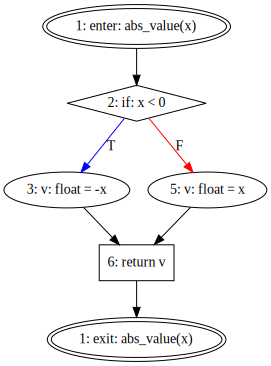

In [42]:
show_cfg(abs_value)

What can we say about the value of `v` at `line: 5`? Let us trace and see. First, we have variable `x` at `line: 1`.

In [43]:
(x,), r = get_symbolicparams(abs_value)

At `line: 2`, we face a bifurcation in the possible paths. Hence, we produce two paths with corresponding constraints.

In [44]:
l2_F = x < 0
l2_T = z3.Not(x < 0)

For `line: 3`, we only need to consider the `If` path. However, we have an assignment. So we use a new variable here. The type _float_ is indicated in the source, and its equivalent *z3* type is _Real_.

In [45]:
v_0 = z3.Real('v_0')
l3 = z3.And(l2_F, v_0 == -x)

Similarly, for `line: 5`, we have an assignment. (Can we reuse the variable `v_0` from before?)

In [46]:
v_1 = z3.Real('v_1')
l5 = z3.And(l2_T, v_1 == x)

When we come to `line: 6`, we see that we have *two* input streams. We have a choice. We can either keep each path separate as we did previously.

In [47]:
v = z3.Real('v')
for s in [z3.And(l3, v == v_0), z3.And(l5, v == v_1)]:
    z3.solve(x != 0, s)

[v_0 = 1/2, v = 1/2, x = -1/2]
[v = 1, v_1 = 1, x = 1]


Or, we can combine them together and produce a single predicate at `line: 6`.

In [48]:
v = z3.Real('v')
l6 = z3.Or(z3.And(l3, v == v_0), z3.And(l5, v == v_1))
z3.solve(l6)

[v_0 = 1/2, v = 1/2, v_1 = 0, x = -1/2]


**Note.** Merging two incoming streams of execution can be non-trivial, especially when the execution paths are traversed multiple times (E.g. loops and recursion). For those interested, lookup [inferring loop invariants](https://www.st.cs.uni-saarland.de/publications/details/galeotti-hvc-2014/).

We can get this to produce any number of solutions for `abs()` as below.

In [49]:
s = z3.Solver()
s.add(l6)
for i in range(5):
    if s.check() == z3.sat:
        m = s.model()
        x_val = m[x]
        print(m)
    else:
        print('no solution')
        break
    s.add(z3.Not(x == x_val))
s

[v_0 = 1/4, v = 1/4, v_1 = -1/4, x = -1/4]
[v_0 = 5/4, v = 5/4, x = -5/4]
[v_0 = 9/4, v = 9/4, x = -9/4]
[v_0 = 13/4, v = 13/4, x = -13/4]
[v_0 = 17/4, v = 17/4, x = -17/4]


[Or(And(And(x < 0, v_0 == -x), v == v_0),
    And(And(Not(x < 0), v_1 == x), v == v_1)),
 Not(-1/4 == x),
 Not(-5/4 == x),
 Not(-9/4 == x),
 Not(-13/4 == x),
 Not(-17/4 == x)]

The solver is not particularly random. So we need to help it a bit to produce values on the negative range.

In [50]:
s.add(x < 0)
for i in range(5):
    if s.check() == z3.sat:
        m = s.model()
        x_val = m[x]
        print(m)
    else:
        print('no solution')
        break
    s.add(z3.Not(x == x_val))

s

[v_0 = 21/4, v = 21/4, x = -21/4]
[v_0 = 25/4, v = 25/4, x = -25/4]
[v_0 = 29/4, v = 29/4, x = -29/4]
[v_0 = 33/4, v = 33/4, x = -33/4]
[v_0 = 37/4, v = 37/4, x = -37/4]


[Or(And(And(x < 0, v_0 == -x), v == v_0),
    And(And(Not(x < 0), v_1 == x), v == v_1)),
 Not(-1/4 == x),
 Not(-5/4 == x),
 Not(-9/4 == x),
 Not(-13/4 == x),
 Not(-17/4 == x),
 x < 0,
 Not(-21/4 == x),
 Not(-25/4 == x),
 Not(-29/4 == x),
 Not(-33/4 == x),
 Not(-37/4 == x)]

Note that the single expression produced at `line: 6` is essentially a summary for `abs_value()`. 

In [51]:
abs_value_summary = l6
abs_value_summary

Or(And(And(x < 0, v_0 == -x), v == v_0),
   And(And(Not(x < 0), v_1 == x), v == v_1))

The *z3* solver can be used to simplify the predicates where possible.

In [52]:
z3.simplify(l6)

Or(And(Not(0 <= x), v_0 == -1*x, v == v_0),
   And(0 <= x, v_1 == x, v == v_1))

One can use this summary rather than trace into `abs_value()` when `abs_value()` is used elsewhere. However, that presents us with a problem. It is possible that the same function may be called multiple times. In this case, using the same variables will lead to collision. One way to avoid that is to *prefix* some call specific value to the variables.

**Note:** The SMT 2.0 standard allows one to define functions (*macros* in SMT parlance) directly. For example, the `abs-value` will be defined as follows:

```lisp
(define-fun abs-value ((x Int)) Int
       (if (> x 0)
           x
           (* -1 x)))
```

Or equivalantly, (especially if `abs-value` is recursively defined)

```lisp
(declare-fun abs-value (Int) Int)
(assert (forall ((x Int))
                (= (abs-value x)
                   (if (> x 0)
                       x
                       (* -1 x)))))
```
One can then say
```
(> (abs-value x) (abs-value y))
```

Unfortunately, the z3py project does not expose this facility in Python. Hence we have to use the `prefix_vars()` hack.

In [53]:
import ast
import astor

The method `prefix_vars()` modifies the variables in an expression such that the variables are prefixed with a given value.

In [54]:
def prefix_vars(astnode, prefix):
    if isinstance(astnode, ast.BoolOp):
        return ast.BoolOp(astnode.op,
                          [prefix_vars(i, prefix) for i in astnode.values], [])
    elif isinstance(astnode, ast.BinOp):
        return ast.BinOp(
            prefix_vars(astnode.left, prefix), astnode.op,
            prefix_vars(astnode.right, prefix))
    elif isinstance(astnode, ast.UnaryOp):
        return ast.UnaryOp(astnode.op, prefix_vars(astnode.operand, prefix))
    elif isinstance(astnode, ast.Call):
        return ast.Call(prefix_vars(astnode.func, prefix),
                        [prefix_vars(i, prefix) for i in astnode.args],
                        astnode.keywords)
    elif isinstance(astnode, ast.Compare):
        return ast.Compare(
            prefix_vars(astnode.left, prefix), astnode.ops,
            [prefix_vars(i, prefix) for i in astnode.comparators])
    elif isinstance(astnode, ast.Name):
        if astnode.id in {'And', 'Or', 'Not'}:
            return ast.Name('z3.%s' % (astnode.id), astnode.ctx)
        else:
            return ast.Name('%s%s' % (prefix, astnode.id), astnode.ctx)
    elif isinstance(astnode, ast.Return):
        return ast.Return(prefix_vars(astnode.value, env))
    else:
        return astnode

For applying `prefix_vars()` one needs the AST of Python expression involved.
When parsing Python source code, it comes wrapped in a `Module` by default.

In [55]:
ast.parse('x+y')

Hence, for easier manipulation of expression AST, we define `get_expression()` which unwraps it and returns the AST representation of the expression inside.

In [56]:
def get_expression(src):
    return ast.parse(src).body[0].value

It is used as follows:

In [57]:
e = get_expression('x+y')
e

The function `to_src()` allows us to *unparse* an expression.

In [58]:
def to_src(astnode):
    return astor.to_source(astnode).strip()

It is used as follows:

In [59]:
to_src(e)

'(x + y)'

We can combine both pieces to produce a prefixed expression as below.

In [60]:
abs_value_summary_ast = get_expression(str(abs_value_summary))
print(to_src(prefix_vars(abs_value_summary_ast, 'x1_')))

z3.Or(z3.And(z3.And(x1_x < 0, x1_v_0 == -x1_x), x1_v == x1_v_0), z3.And(
    z3.And(z3.Not(x1_x < 0), x1_v_1 == x1_x), x1_v == x1_v_1))


#### Get Names and Types of Variables Used

What about the declarations used? Given that we have all equations in *Z3*, we can retrieve this information directly. We define `z3_names_and_types()` that takes in a *Z3* expression, and extracts the variable definitions required.

In [61]:
def z3_names_and_types(z3_ast):
    hm = {}
    children = z3_ast.children()
    if children:
        for c in children:
            hm.update(z3_names_and_types(c))
    else:
        # HACK.. How else to distinguish literals and vars?
        if (str(z3_ast.decl()) != str(z3_ast.sort())):
            hm["%s" % str(z3_ast.decl())] = 'z3.%s' % str(z3_ast.sort())
        else:
            pass
    return hm

In [62]:
abs_value_declarations = z3_names_and_types(abs_value_summary)
abs_value_declarations

{'x': 'z3.Real', 'v_0': 'z3.Real', 'v': 'z3.Real', 'v_1': 'z3.Real'}

However, `z3_names_and_types()` is limited in that it requires the *Z3* AST to operate. Hence, we also define `used_identifiers()` that can extract  identifiers directly from the string representation of any Python expression, (including *Z3* constraints). One trade-off here is that we lose track of the type information. But we will see how to recover that later.

In [63]:
def used_identifiers(src):
    def names(astnode):
        lst = []
        if isinstance(astnode, ast.BoolOp):
            for i in astnode.values:
                lst.extend(names(i))
        elif isinstance(astnode, ast.BinOp):
            lst.extend(names(astnode.left))
            lst.extend(names(astnode.right))
        elif isinstance(astnode, ast.UnaryOp):
            lst.extend(names(astnode.operand))
        elif isinstance(astnode, ast.Call):
            for i in astnode.args:
                lst.extend(names(i))
        elif isinstance(astnode, ast.Compare):
            lst.extend(names(astnode.left))
            for i in astnode.comparators:
                lst.extend(names(i))
        elif isinstance(astnode, ast.Name):
            lst.append(astnode.id)
        elif isinstance(astnode, ast.Expr):
            lst.extend(names(astnode.value))
        elif isinstance(astnode, (ast.Num, ast.Str, ast.Tuple, ast.NameConstant)):
            pass
        elif isinstance(astnode, ast.Assign):
            for t in astnode.targets:
                lst.extend(names(t))
            lst.extend(names(astnode.value))
        elif isinstance(astnode, ast.Module):
            for b in astnode.body:
                lst.extend(names(b))
        else:
            raise Exception(str(astnode))
        return list(set(lst))
    return names(ast.parse(src))

In [64]:
used_identifiers(str(abs_value_summary))

['v_0', 'v', 'x', 'v_1']

We can now register the function summary `abs_value` for later use.

In [65]:
Function_Summaries = {}
Function_Summaries['abs_value'] = {
    'predicate': str(abs_value_summary),
    'vars': abs_value_declarations}

As we mentioned previously, we do not want to rely on *Z3* to extract the type information. A better alternative is to let the user specify the type information as annotations, and extract this information from the program. We will see next how this can be achieved.

First, we convert the *Python type to Z3 type* map to its string equivalent.

In [66]:
SYM_VARS_STR = {
    k.__name__: ("z3.%s" % v1.__name__, "z3.%s" % v2.__name__)
    for k, (v1, v2) in SYM_VARS.items()
}
SYM_VARS_STR

{'int': ('z3.Int', 'z3.IntVal'),
 'float': ('z3.Real', 'z3.RealVal'),
 'str': ('z3.String', 'z3.StringVal')}

We also define a convenience method `translate_to_z3_name()` for accessing the *Z3* type for symbolic variables.

In [67]:
def translate_to_z3_name(v):
    return SYM_VARS_STR[v][0]

We now define the method `declarations()` that extracts variables used in Python _statements_. The idea is to look for augmented assignments that contain annotated type information. These are collected and returned.

If there are `call` nodes, they represent function calls. The used variables in these function calls are recovered from the corresponding function summaries.

In [68]:
def declarations(astnode, hm=None):
    if hm is None:
        hm = {}
    if isinstance(astnode, ast.Module):
        for b in astnode.body:
            declarations(b, hm)
    elif isinstance(astnode, ast.FunctionDef):
        #hm[astnode.name + '__return__'] = translate_to_z3_name(astnode.returns.id)
        for a in astnode.args.args:
            hm[a.arg] = translate_to_z3_name(a.annotation.id)
        for b in astnode.body:
            declarations(b, hm)
    elif isinstance(astnode, ast.Call):
        # get declarations from the function summary.
        n = astnode.function
        assert isinstance(n, ast.Name)  # for now.
        name = n.id
        hm.update(dict(Function_Summaries[name]['vars']))
    elif isinstance(astnode, ast.AnnAssign):
        assert isinstance(astnode.target, ast.Name)
        hm[astnode.target.id] = translate_to_z3_name(astnode.annotation.id)
    elif isinstance(astnode, ast.Assign):
        # verify it is already defined
        for t in astnode.targets:
            assert isinstance(t, ast.Name)
            assert t.id in hm
    elif isinstance(astnode, ast.AugAssign):
        assert isinstance(astnode.target, ast.Name)
        assert astnode.target.id in hm
    elif isinstance(astnode, (ast.If, ast.For, ast.While)):
        for b in astnode.body:
            declarations(b, hm)
        for b in astnode.orelse:
            declarations(b, hm)
    elif isinstance(astnode, ast.Return):
        pass
    else:
        raise Exception(str(astnode))
    return hm

With this, we can now extract the variables used in an expression.

In [69]:
declarations(ast.parse('s: int = 3\np: float = 4.0\ns += 1'))

{'s': 'z3.Int', 'p': 'z3.Real'}

We wrap `declarations()` in the method `used_vars()` that operates directly on function objects.

In [70]:
def used_vars(fn):
    return declarations(ast.parse(inspect.getsource(fn)))

Here is how it can be used:

In [71]:
used_vars(check_triangle)

{'a': 'z3.Int', 'b': 'z3.Int', 'c': 'z3.Int'}

In [72]:
used_vars(abs_value)

{'x': 'z3.Real', 'v': 'z3.Real'}

Given the extracted variables and their *Z3* types, we need a way to reinstantiate them when needed. We define `define_symbolic_vars()` that translates these descriptions to a form that can be directly `exec()`ed.

In [73]:
def define_symbolic_vars(fn_vars, prefix):
    sym_var_dec = ', '.join([prefix + n for n in fn_vars])
    sym_var_def = ', '.join(["%s('%s%s')" % (t, prefix, n)
                             for n, t in fn_vars.items()])
    return "%s = %s" % (sym_var_dec, sym_var_def)

Here is how it can be used:

In [74]:
define_symbolic_vars(abs_value_declarations, '')

"x, v_0, v, v_1 = z3.Real('x'), z3.Real('v_0'), z3.Real('v'), z3.Real('v_1')"

We next define `gen_fn_summary()` that returns a function summary in instantiable form using *Z3*. 

In [75]:
def gen_fn_summary(prefix, fn):
    summary = Function_Summaries[fn.__name__]['predicate']
    fn_vars = Function_Summaries[fn.__name__]['vars']
    decl = define_symbolic_vars(fn_vars, prefix)
    summary_ast = get_expression(summary)
    return decl, to_src(prefix_vars(summary_ast, prefix))

Here is how it can be used:

In [76]:
gen_fn_summary('a_', abs_value)

("a_x, a_v_0, a_v, a_v_1 = z3.Real('a_x'), z3.Real('a_v_0'), z3.Real('a_v'), z3.Real('a_v_1')",
 'z3.Or(z3.And(z3.And(a_x < 0, a_v_0 == -a_x), a_v == a_v_0), z3.And(z3.And(\n    z3.Not(a_x < 0), a_v_1 == a_x), a_v == a_v_1))')

In [77]:
gen_fn_summary('b_', abs_value)

("b_x, b_v_0, b_v, b_v_1 = z3.Real('b_x'), z3.Real('b_v_0'), z3.Real('b_v'), z3.Real('b_v_1')",
 'z3.Or(z3.And(z3.And(b_x < 0, b_v_0 == -b_x), b_v == b_v_0), z3.And(z3.And(\n    z3.Not(b_x < 0), b_v_1 == b_x), b_v == b_v_1))')

How do we use our function summaries? Here is a function `abs_max()` that uses `abs_value()`.

In [78]:
def abs_max(a: float, b: float):
    a1: float = abs_value(a)
    b1: float = abs_value(b)
    if a1 > b1:
        c: float = a1
    else:
        c: float = b1
    return c

To trace this function symbolically, we first define the two variables `a` and `b`.

In [79]:
a = z3.Real('a')
b = z3.Real('b')

The `line: 2` contains definition for `a1`, which we define as a symbolic variable.

In [80]:
a1 = z3.Real('a1')

We also need to call `abs_value()`, which is accomplished as follows. Since this is the first call to `abs_value()`, we use `abs1` as the prefix.

In [81]:
d, v = gen_fn_summary('abs1_', abs_value)
d, v

("abs1_x, abs1_v_0, abs1_v, abs1_v_1 = z3.Real('abs1_x'), z3.Real('abs1_v_0'), z3.Real('abs1_v'), z3.Real('abs1_v_1')",
 'z3.Or(z3.And(z3.And(abs1_x < 0, abs1_v_0 == -abs1_x), abs1_v == abs1_v_0),\n    z3.And(z3.And(z3.Not(abs1_x < 0), abs1_v_1 == abs1_x), abs1_v == abs1_v_1))')

We also need to equate the resulting value (`<prefix>_v`) to the symbolic variable `a1` we defined earlier.

In [82]:
l2_src = "l2 = z3.And(a == abs1_x, a1 == abs1_v, %s)" % v
l2_src

'l2 = z3.And(a == abs1_x, a1 == abs1_v, z3.Or(z3.And(z3.And(abs1_x < 0, abs1_v_0 == -abs1_x), abs1_v == abs1_v_0),\n    z3.And(z3.And(z3.Not(abs1_x < 0), abs1_v_1 == abs1_x), abs1_v == abs1_v_1)))'

Applying both declaration and the assignment.

In [83]:
exec(d)
exec(l2_src)

In [84]:
l2

And(a == abs1_x,
    a1 == abs1_v,
    Or(And(And(abs1_x < 0, abs1_v_0 == -abs1_x),
           abs1_v == abs1_v_0),
       And(And(Not(abs1_x < 0), abs1_v_1 == abs1_x),
           abs1_v == abs1_v_1)))

We need to do the same for `line: 3`, but with `abs2` as the prefix.

In [85]:
b1 = z3.Real('b1')
d, v = gen_fn_summary('abs2_', abs_value)
l3_src = "l3_ = z3.And(b == abs2_x, b1 == abs2_v, %s)" % v
exec(d)
exec(l3_src)

In [86]:
l3_

And(b == abs2_x,
    b1 == abs2_v,
    Or(And(And(abs2_x < 0, abs2_v_0 == -abs2_x),
           abs2_v == abs2_v_0),
       And(And(Not(abs2_x < 0), abs2_v_1 == abs2_x),
           abs2_v == abs2_v_1)))

To get the true set of predicates at `line: 3`, we need to add the predicates from `line: 2`.

In [87]:
l3 = z3.And(l2, l3_)

In [88]:
l3

And(And(a == abs1_x,
        a1 == abs1_v,
        Or(And(And(abs1_x < 0, abs1_v_0 == -abs1_x),
               abs1_v == abs1_v_0),
           And(And(Not(abs1_x < 0), abs1_v_1 == abs1_x),
               abs1_v == abs1_v_1))),
    And(b == abs2_x,
        b1 == abs2_v,
        Or(And(And(abs2_x < 0, abs2_v_0 == -abs2_x),
               abs2_v == abs2_v_0),
           And(And(Not(abs2_x < 0), abs2_v_1 == abs2_x),
               abs2_v == abs2_v_1))))

This equation can be simplified a bit using z3.

In [89]:
z3.simplify(l3)

And(a == abs1_x,
    a1 == abs1_v,
    Or(And(Not(0 <= abs1_x),
           abs1_v_0 == -1*abs1_x,
           abs1_v == abs1_v_0),
       And(0 <= abs1_x,
           abs1_v_1 == abs1_x,
           abs1_v == abs1_v_1)),
    b == abs2_x,
    b1 == abs2_v,
    Or(And(Not(0 <= abs2_x),
           abs2_v_0 == -1*abs2_x,
           abs2_v == abs2_v_0),
       And(0 <= abs2_x,
           abs2_v_1 == abs2_x,
           abs2_v == abs2_v_1)))

Coming to `line: 4`, we have a condition.

In [90]:
l4_cond = a1 > b1
l4 = z3.And(l3, l4_cond)

For `line: 5`, we define the symbolic variable `c_0` assuming we took the *IF* branch.

In [91]:
c_0 = z3.Real('c_0')
l5 = z3.And(l4, c_0 == a1)

For `line: 6`, the *ELSE* branch was taken. So we invert that condition.

In [92]:
l6 = z3.And(l3, z3.Not(l4_cond))

For `line: 7`, we define `c_1`.

In [93]:
c_1 = z3.Real('c_1')
l7 = z3.And(l6, c_1 == b1)

In [94]:
s1 = z3.Solver()
s1.add(l5)
s1.check()

sat

In [95]:
m1 = s1.model()
sorted([(d, m1[d]) for d in m1.decls() if not d.name(
).startswith('abs')], key=lambda x: x[0].name())

[(a, 1/2), (a1, 1/2), (b, 0), (b1, 0), (c_0, 1/2)]

In [96]:
s2 = z3.Solver()
s2.add(l7)
s2.check()

sat

In [97]:
m2 = s2.model()
sorted([(d, m2[d]) for d in m2.decls() if not d.name(
).startswith('abs')], key=lambda x: x[0].name())

[(a, 0), (a1, 0), (b, 0), (b1, 0), (c_1, 0)]

What we really want to do is to automate this process, because doing this by hand is tedious and error prone. Essentially, we want the ability to extract *all paths* in the program, and symbolically execute each path, which will generate the inputs required to cover all reachable portions of the program.

## SimpleSymbolicFuzzer

We define a simple *symbolic fuzzer* that can generate input values *symbolically* with the following assumptions:

* There are no loops in the program
* The function is self contained.
* No recursion.
* No reassignments for variables.

The key idea is as follows: We traverse through the control flow graph from the entry point, and generate all possible paths to a given depth. Then we collect constraints that we encountered along the path, and generate inputs that will traverse the program up to that point.

We build our fuzzer based on the class `Fuzzer`.

In [98]:
from Fuzzer import Fuzzer

We start by extracting the control flow graph of the function passed. We also provide a hook for child classes to do their processing.

In [99]:
class SimpleSymbolicFuzzer(Fuzzer):
    def __init__(self, fn, **kwargs):
        self.fn_name = fn.__name__
        py_cfg = PyCFG()
        py_cfg.gen_cfg(inspect.getsource(fn))
        self.fnenter, self.fnexit = py_cfg.functions[self.fn_name]
        self.used_variables = used_vars(fn)
        self.fn_args = list(inspect.signature(fn).parameters)
        self.z3 = z3.Solver()

        self.paths = None
        self.last_path = None

        self.options(kwargs)
        self.process()

    def process(self):
        pass

We need a few variables to control how much we are willing to traverse.

`MAX_DEPTH` is the depth to which one should attempt to trace the execution.

In [100]:
MAX_DEPTH = 100

`MAX_TRIES` is the maximum number of attempts we will try to produce a value before giving up.

In [101]:
MAX_TRIES = 100

`MAX_ITER` is the number of iterations we will attempt.

In [102]:
MAX_ITER = 100

The `options()` method sets these parameters in the fuzzing class.

In [103]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def options(self, kwargs):
        self.max_depth = kwargs.get('max_depth', MAX_DEPTH)
        self.max_tries = kwargs.get('max_tries', MAX_TRIES)
        self.max_iter = kwargs.get('max_iter', MAX_ITER)
        self._options = kwargs

The initialization generates a control flow graph and hooks it to `fnenter` and `fnexit`.

In [104]:
symfz_ct = SimpleSymbolicFuzzer(check_triangle)

In [105]:
symfz_ct.fnenter, symfz_ct.fnexit

(id:9 line[1] parents: [] : enter: check_triangle(a, b, c),
 id:10 line[1] parents: [14, 15, 16, 19, 20, 21] : exit: check_triangle(a, b, c))

### Generating All Possible Paths
We can use the procedure `get_all_paths()` starting from `fnenter` to recursively retrieve all paths in the function.

The idea is as follows: Start with the function entry point `fnenter`, and recursively follow the children using the CFG. At any node there is a branching, there would be multiple children. On other nodes there would be only one child. Let us say a node had $n$ children. Such a node would result in $n$ paths. We attach the current node to the head of each paths, and return all paths thus generated.

In [106]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def get_all_paths(self, fenter, depth=0):
        if depth > self.max_depth:
            raise Exception('Maximum depth exceeded')
        if not fenter.children:
            return [[(0, fenter)]]

        fnpaths = []
        for idx, child in enumerate(fenter.children):
            child_paths = self.get_all_paths(child, depth + 1)
            for path in child_paths:
                # In a conditional branch, idx is 0 for IF, and 1 for Else
                fnpaths.append([(idx, fenter)] + path)
        return fnpaths

This can be used as follows.

In [107]:
symfz_ct = SimpleSymbolicFuzzer(check_triangle)
paths = symfz_ct.get_all_paths(symfz_ct.fnenter)
print(len(paths))
paths[1]

6


[(0, id:24 line[1] parents: [] : enter: check_triangle(a, b, c)),
 (0, id:26 line[2] parents: [24] : _if: a == b),
 (0, id:27 line[3] parents: [26] : _if: a == c),
 (1, id:28 line[4] parents: [27] : _if: b == c),
 (0, id:30 line[7] parents: [28] : return 'Isosceles'),
 (0,
  id:25 line[1] parents: [29, 30, 31, 34, 35, 36] : exit: check_triangle(a, b, c))]

We hook `get_all_paths()` to initialization as below.

In [108]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def process(self):
        self.paths = self.get_all_paths(self.fnenter)
        self.last_path = len(self.paths)

### Extracting All Constraints

For any given path, we define a function `extract_constraints()` to extract the constraints such that they are executable directly with *Z3*. The `idx` represents the particular branch that was taken. Hence, if the `False` branch was taken in a conditional, we attach a negation of the conditional.

In [109]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def extract_constraints(self, path):
        predicates = []
        for (idx, elt) in path:
            if isinstance(elt.ast_node, ast.AnnAssign):
                if elt.ast_node.target.id in {'_if', '_while'}:
                    s = to_src(elt.ast_node.annotation)
                    predicates.append(("%s" if idx == 0 else "z3.Not%s") % s)
                elif isinstance(elt.ast_node.annotation, ast.Call):
                    assert elt.ast_node.annotation.func.id == self.fn_name
                else:
                    node = elt.ast_node
                    t = ast.Compare(node.target, [ast.Eq()], [node.value])
                    predicates.append(to_src(t))
            elif isinstance(elt.ast_node, ast.Assign):
                node = elt.ast_node
                t = ast.Compare(node.targets[0], [ast.Eq()], [node.value])
                predicates.append(to_src(t))
            else:
                pass
        return predicates

In [110]:
symfz_ct = SimpleSymbolicFuzzer(check_triangle)
paths = symfz_ct.get_all_paths(symfz_ct.fnenter)
symfz_ct.extract_constraints(paths[0])

['(a == b)', '(a == c)', '(b == c)']

In [111]:
constraints = symfz_ct.extract_constraints(paths[1])
constraints

['(a == b)', '(a == c)', 'z3.Not(b == c)']

### Fuzzing with Simple Symbolic Fuzzer

To actually generate solutions, we define `fuzz()`. For that, we need to first extract all paths. Then choose a particular path, and extract the constraints in that path, which is then solved using *z3*.

In [112]:
from contextlib import contextmanager

First we create a checkpoint for our current solver so that we can check a predicate, and rollback if necessary.

In [113]:
@contextmanager
def checkpoint(z3solver):
    z3solver.push()
    yield z3solver
    z3solver.pop()

The `use_path()` function extracts constraints for a single function, applies it to our current solver (under a checkpoint), and returns the results if some solutions can be found.
If solutions were found, we also make sure that we never reuse those solutions.

In [114]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def solve_path_constraint(self, path):
        # re-initializing does not seem problematic.
        # a = z3.Int('a').get_id() remains the same.
        constraints = self.extract_constraints(path)
        decl = define_symbolic_vars(self.used_variables, '')
        exec(decl)

        solutions = {}
        with checkpoint(self.z3):
            st = 'self.z3.add(%s)' % ', '.join(constraints)
            eval(st)
            if self.z3.check() != z3.sat:
                return {}
            m = self.z3.model()
            solutions = {d.name(): m[d] for d in m.decls()}
            my_args = {k: solutions.get(k, None) for k in self.fn_args}
        predicate = 'z3.And(%s)' % ','.join(
            ["%s == %s" % (k, v) for k, v in my_args.items()])
        eval('self.z3.add(z3.Not(%s))' % predicate)
        return my_args

We define `get_path()` that retrieves the current path and updates the path used.

In [115]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def get_next_path(self):
        self.last_path -= 1
        if self.last_path == -1:
            self.last_path = len(self.paths) - 1
        return self.paths[self.last_path]

The `fuzz()` method simply solves each path in order.

In [116]:
class SimpleSymbolicFuzzer(SimpleSymbolicFuzzer):
    def fuzz(self):
        for i in range(self.max_tries):
            res = self.solve_path_constraint(self.get_next_path())
            if res:
                return res
        return {}

The fuzzer can be used as follows.

In [117]:
a, b, c = None, None, None
symfz_ct = SimpleSymbolicFuzzer(check_triangle)
for i in range(1, 10):
    r = symfz_ct.fuzz()
    v = check_triangle(r['a'].as_long(), r['b'].as_long(), r['c'].as_long())
    print(r, "result:", v)

{'a': 0, 'b': 1, 'c': 1} result: Isosceles
{'a': 1, 'b': 3, 'c': 2} result: Scalene
{'a': 0, 'b': 2, 'c': 0} result: Isosceles
{'a': 3, 'b': 3, 'c': 0} result: Isosceles
{'a': 2, 'b': 2, 'c': 2} result: Equilateral
{'a': 1, 'b': 3, 'c': 3} result: Isosceles
{'a': 1, 'b': 5, 'c': 4} result: Scalene
{'a': 0, 'b': 4, 'c': 0} result: Isosceles
{'a': 5, 'b': 5, 'c': 0} result: Isosceles


In [118]:
symfz_av = SimpleSymbolicFuzzer(abs_value)
for i in range(1, 10):
    r = symfz_av.fuzz()
    v = abs_value(r['x'].numerator_as_long() / r['x'].denominator_as_long())
    print(r, "result:", v)

{'x': 0} result: 0.0
{'x': -1} result: 1.0
{'x': 1} result: 1.0
{'x': -2} result: 2.0
{'x': 1/2} result: 0.5
{'x': -3/2} result: 1.5
{'x': 2} result: 2.0
{'x': -3} result: 3.0
{'x': 3/2} result: 1.5


The _SimpleSymbolicFuzzer_ seems to work well for the _simple_ programs we checked above.

### Problems with the Simple Fuzzer

As we mentioned earlier, the `SimpleSymbolicFuzzer` cannot yet deal with variable reassignments. Further, it also fails to account for any loops. For example, consider the following program.

In [119]:
def gcd(a: int, b: int) -> int:
    if a < b:
        c: int = a
        a = b
        b = c

    while b != 0:
        c: int = a
        a = b
        b = c % b
    return a

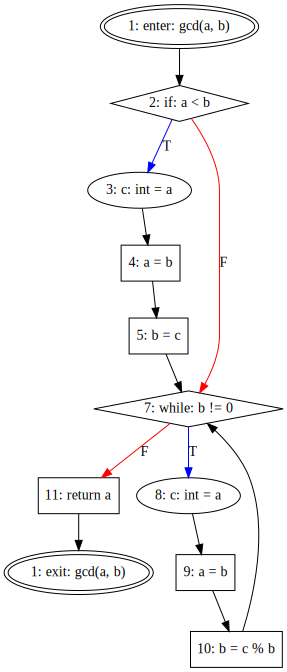

In [120]:
show_cfg(gcd)

In [121]:
from ExpectError import ExpectError

In [122]:
with ExpectError():
    symfz_gcd = SimpleSymbolicFuzzer(gcd, max_depth=1000, max_iter=10)
    for i in range(1, 100):
        r = symfz_gcd.fuzz()
        v = gcd(r['a'].as_long(), r['b'].as_long())
        print(r, v)

Traceback (most recent call last):
  File "<ipython-input-122-81ef1b3c9fa1>", line 2, in <module>
    symfz_gcd = SimpleSymbolicFuzzer(gcd, max_depth=1000, max_iter=10)
  File "<ipython-input-99-bfa1b98c03e8>", line 15, in __init__
    self.process()
  File "<ipython-input-108-6bc97a9e8eb0>", line 3, in process
    self.paths = self.get_all_paths(self.fnenter)
  File "<ipython-input-106-3dd7b055ae0f>", line 10, in get_all_paths
    child_paths = self.get_all_paths(child, depth + 1)
  File "<ipython-input-106-3dd7b055ae0f>", line 10, in get_all_paths
    child_paths = self.get_all_paths(child, depth + 1)
  File "<ipython-input-106-3dd7b055ae0f>", line 10, in get_all_paths
    child_paths = self.get_all_paths(child, depth + 1)
  [Previous line repeated 998 more times]
  File "<ipython-input-106-3dd7b055ae0f>", line 4, in get_all_paths
    raise Exception('Maximum depth exceeded')
Exception: Maximum depth exceeded (expected)


The problem here is that our *SimpleSymbolicFuzzer* has no concept of loops and variable reassignments. We will see how to fix this shortcoming next.

## Advanced Symbolic Fuzzer

We next define `AdvancedSymbolicFuzzer` that can deal with reassignments and *unrolling of loops*.

In [123]:
class AdvancedSymbolicFuzzer(SimpleSymbolicFuzzer):
    def options(self, kwargs):
        super().options(kwargs)

Once we allow reassignments and loop unrolling, we have to deal with what to call the new variables generated. This is what we will tackle next.

### Dealing with Reassingments

We want to rename all variables present in an expression such that the variables are annotated with their usage count. This makes it possible to determine variable reassignments.  To do that, we define the `rename_variables()` function that, when given an `env` that contains the current usage index of different variables, renames the variables in the passed in AST node with the annotations, and returns a copy with the modifications. Note that we can't use [NodeTransformer](https://docs.python.org/3/library/ast.html#ast.NodeTransformer) here as it would modify the AST.

That is, if the expression is `env[v] == 1`, `v` is renamed to `_v_1`

In [124]:
def rename_variables(astnode, env):
    if isinstance(astnode, ast.BoolOp):
        fn = 'z3.And' if isinstance(astnode.op, ast.And) else 'z3.Or'
        return ast.Call(
            ast.Name(fn, None),
            [rename_variables(i, env) for i in astnode.values], [])
    elif isinstance(astnode, ast.BinOp):
        return ast.BinOp(
            rename_variables(astnode.left, env), astnode.op,
            rename_variables(astnode.right, env))
    elif isinstance(astnode, ast.UnaryOp):
        if isinstance(astnode.op, ast.Not):
            return ast.Call(
                ast.Name('z3.Not', None),
                [rename_variables(astnode.operand, env)], [])
        else:
            return ast.UnaryOp(astnode.op,
                               rename_variables(astnode.operand, env))
    elif isinstance(astnode, ast.Call):
        return ast.Call(astnode.func,
                        [rename_variables(i, env) for i in astnode.args],
                        astnode.keywords)
    elif isinstance(astnode, ast.Compare):
        return ast.Compare(
            rename_variables(astnode.left, env), astnode.ops,
            [rename_variables(i, env) for i in astnode.comparators])
    elif isinstance(astnode, ast.Name):
        if astnode.id not in env:
            env[astnode.id] = 0
        num = env[astnode.id]
        return ast.Name('_%s_%d' % (astnode.id, num), astnode.ctx)
    elif isinstance(astnode, ast.Return):
        return ast.Return(rename_variables(astnode.value, env))
    else:
        return astnode

To verify that it works as intended, we start with an environment.

In [125]:
env = {'x': 1}

In [126]:
ba = get_expression('x == 1 and y == 2')
type(ba)

_ast.BoolOp

In [127]:
assert to_src(rename_variables(ba, env)) == 'z3.And(_x_1 == 1, _y_0 == 2)'

In [128]:
bo = get_expression('x == 1 or y == 2')
type(bo.op)

_ast.Or

In [129]:
assert to_src(rename_variables(bo, env)) == 'z3.Or(_x_1 == 1, _y_0 == 2)'

In [130]:
b = get_expression('x + y')
type(b)

_ast.BinOp

In [131]:
assert to_src(rename_variables(b, env)) == '(_x_1 + _y_0)'

In [132]:
u = get_expression('-y')
type(u)

_ast.UnaryOp

In [133]:
assert to_src(rename_variables(u, env)) == '(-_y_0)'

In [134]:
un = get_expression('not y')
type(un.op)

_ast.Not

In [135]:
assert to_src(rename_variables(un, env)) == 'z3.Not(_y_0)'

In [136]:
c = get_expression('x == y')
type(c)

_ast.Compare

In [137]:
assert to_src(rename_variables(c, env)) == '(_x_1 == _y_0)'

In [138]:
f = get_expression('fn(x,y)')
type(f)

_ast.Call

In [139]:
assert to_src(rename_variables(f, env)) == 'fn(_x_1, _y_0)'

In [140]:
env

{'x': 1, 'y': 0}

Next, we want to process the CFG, and correctly transform the paths.

### Tracking Assignments

For keeping track of assignments in the CFG, We define a data structure `PNode` that stores the current CFG node.

In [141]:
class PNode:
    def __init__(self, idx, cfgnode, parent=None, order=0, seen=None):
        self.seen = {} if seen is None else seen
        self.max_iter = MAX_ITER
        self.idx, self.cfgnode, self.parent, self.order = idx, cfgnode, parent, order

    def __repr__(self):
        return "PNode:%d[%s order:%d]" % (self.idx, str(self.cfgnode),
                                          self.order)

Defining a new `PNode` is done as follows.

In [142]:
cfg = PyCFG()
cfg.gen_cfg(inspect.getsource(gcd))
gcd_fnenter, _ = cfg.functions['gcd']

In [143]:
PNode(0, gcd_fnenter)

PNode:0[id:27 line[1] parents: [] : enter: gcd(a, b) order:0]

The `copy()` method generates a copy for the child's keep, indicating which path was taken (with `order` of the child).

In [144]:
class PNode(PNode):
    def copy(self, order):
        p = PNode(self.idx, self.cfgnode, self.parent, order, self.seen)
        assert p.order == order
        return p

Using the copy operation.

In [145]:
PNode(0, gcd_fnenter).copy(1)

PNode:0[id:27 line[1] parents: [] : enter: gcd(a, b) order:1]

#### Stepwise Exploration of Paths

A problem we had with our `SimpleSymbolicFuzzer` is that it explored a path to completion before attempting another. However, this is non-optimal. One may want to explore the graph in a more step-wise manner, expanding every possible execution one step at a time.

Hence, we define `explore()`  which explores the children of a node if any, one step at a time. If done exhaustively, this will generate all paths from a starting node until no more children are left. We made `PNode` to a container class so that this iteration can be driven from outside, and stopped if say a maximum iteration is complete, or certain paths need to be prioritized.

In [146]:
class PNode(PNode):
    def explore(self):
        ret = []
        for (i, n) in enumerate(self.cfgnode.children):
            key = "[%d]%s" % (self.idx + 1, n)
            ccount = self.seen.get(key, 0)
            if ccount > self.max_iter:
                continue  # drop this child
            self.seen[key] = ccount + 1
            pn = PNode(self.idx + 1, n, self.copy(i), seen=self.seen)
            ret.append(pn)
        return ret

We can use `explore()` as follows.

In [147]:
PNode(0, gcd_fnenter).explore()

[PNode:1[id:29 line[2] parents: [27] : _if: a < b order:0]]

In [148]:
PNode(0, gcd_fnenter).explore()[0].explore()

[PNode:2[id:30 line[3] parents: [29] : c: int = a order:0],
 PNode:2[id:33 line[7] parents: [32, 29, 36] : _while: b != 0 order:0]]

The method `get_path_to_root()` recursively goes up through child->parent chain retrieving the complete chain to the topmost parent.

In [149]:
class PNode(PNode):
    def get_path_to_root(self):
        path = []
        n = self
        while n:
            path.append(n)
            n = n.parent
        return list(reversed(path))

In [150]:
p = PNode(0, gcd_fnenter)
[s.get_path_to_root() for s in p.explore()[0].explore()[0].explore()[0].explore()]

[[PNode:0[id:27 line[1] parents: [] : enter: gcd(a, b) order:0],
  PNode:1[id:29 line[2] parents: [27] : _if: a < b order:0],
  PNode:2[id:30 line[3] parents: [29] : c: int = a order:0],
  PNode:3[id:31 line[4] parents: [30] : a = b order:0],
  PNode:4[id:32 line[5] parents: [31] : b = c order:0]]]

The string representation of the node is in `z3` solvable form.

In [151]:
class PNode(PNode):
    def __str__(self):
        path = self.get_path_to_root()
        ssa_path = to_single_assignment_predicates(path)
        return ', '.join([to_src(p) for p in ssa_path])

However, before using it, we need to take care of variable renaming so that reassignments can work.

#### Renaming Used Variables

We need to rename used variables. Any variable `v = xxx` should be renamed to `_v_0` and any later assignment such as `v = v + 1` should be transformed to `_v_1 = _v_0 + 1` and later conditionals such as `v == x` should be transformed to `(_v_1 == _x_0)`. The method `to_single_assignment_predicates()` does this for a given path.

In [152]:
def to_single_assignment_predicates(path):
    env = {}
    new_path = []
    for i, node in enumerate(path):
        ast_node = node.cfgnode.ast_node
        new_node = None
        if isinstance(ast_node, ast.AnnAssign) and ast_node.target.id in {
                'exit'}:
            new_node = None
        elif isinstance(ast_node, ast.AnnAssign) and ast_node.target.id in {'enter'}:
            args = [
                ast.parse(
                    "%s == _%s_0" %
                    (a.id, a.id)).body[0].value for a in ast_node.annotation.args]
            new_node = ast.Call(ast.Name('z3.And', None), args, [])
        elif isinstance(ast_node, ast.AnnAssign) and ast_node.target.id in {'_if', '_while'}:
            new_node = rename_variables(ast_node.annotation, env)
            if node.order != 0:
                assert node.order == 1
                new_node = ast.Call(ast.Name('z3.Not', None), [new_node], [])
        elif isinstance(ast_node, ast.AnnAssign):
            assigned = ast_node.target.id
            val = [rename_variables(ast_node.value, env)]
            env[assigned] = 0 if assigned not in env else env[assigned] + 1
            target = ast.Name('_%s_%d' %
                              (ast_node.target.id, env[assigned]), None)
            new_node = ast.Expr(ast.Compare(target, [ast.Eq()], val))
        elif isinstance(ast_node, ast.Assign):
            assigned = ast_node.targets[0].id
            val = [rename_variables(ast_node.value, env)]
            env[assigned] = 0 if assigned not in env else env[assigned] + 1
            target = ast.Name('_%s_%d' %
                              (ast_node.targets[0].id, env[assigned]), None)
            new_node = ast.Expr(ast.Compare(target, [ast.Eq()], val))
        elif isinstance(ast_node, (ast.Return, ast.Pass)):
            new_node = None
        else:
            s = "NI %s %s" % (type(ast_node), ast_node.target.id)
            raise Exception(s)
        new_path.append(new_node)
    return new_path

Here is how it can be used:

In [153]:
p = PNode(0, gcd_fnenter)
path = p.explore()[0].explore()[0].explore()[0].get_path_to_root()
spath = to_single_assignment_predicates(path)

In [154]:
[to_src(s) for s in spath]

['z3.And(a == _a_0, b == _b_0)',
 '(_a_0 < _b_0)',
 '_c_0 == _a_0',
 '_a_1 == _b_0']

#### Check Before You Loop

One of the ways in which the *concolic* execution simplifies *symbolic* execution is in the treatment of loops. Rather than trying to determine an invariant for a loop, we simply *unroll* the loops a number of times until we hit the `MAX_DEPTH` limit. However, not all loops will need to be unrolled until `MAX_DEPTH` is reached. Some of them may exit before. Hence, it is necessary to check whether the given set of constraints can be satisfied before continuing to explore further. 

In [155]:
def identifiers_with_types(identifiers, defined):
    with_types = dict(defined)
    for i in identifiers:
        if i[0] == '_':
            nxt = i[1:].find('_', 1)
            name = i[1:nxt + 1]
            assert name in defined
            typ = defined[name]
            with_types[i] = typ
    return with_types

The `extract_constraints()` generates the `z3` constraints from a path. The main work is done by `to_single_assignment_predicates()`. The `extract_constraints()` then converts the AST to source.

In [156]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def extract_constraints(self, path):
        return [to_src(p) for p in to_single_assignment_predicates(path) if p]

### Solving Path Constraints

We now update our `solve_path_constraint()` method to take into account the new identifiers created during reassignments.

In [157]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def solve_path_constraint(self, path):
        # re-initializing does not seem problematic.
        # a = z3.Int('a').get_id() remains the same.
        constraints = self.extract_constraints(path)
        identifiers = [
            c for i in constraints for c in used_identifiers(i)]  # <- changes
        with_types = identifiers_with_types(
            identifiers, self.used_variables)  # <- changes
        decl = define_symbolic_vars(with_types, '')
        exec(decl)

        solutions = {}
        with checkpoint(self.z3):
            st = 'self.z3.add(%s)' % ', '.join(constraints)
            eval(st)
            if self.z3.check() != z3.sat:
                return {}
            m = self.z3.model()
            solutions = {d.name(): m[d] for d in m.decls()}
            my_args = {k: solutions.get(k, None) for k in self.fn_args}
        predicate = 'z3.And(%s)' % ','.join(
            ["%s == %s" % (k, v) for k, v in my_args.items()])
        eval('self.z3.add(z3.Not(%s))' % predicate)
        return my_args

### Generating All Paths

The `get_all_paths()` is now similarly updated so that we unroll loops only to a specified height. It is also converted to an iterative exploration style so that we explore the CFG in a breadth first manner.

In [158]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def get_all_paths(self, fenter):
        path_lst = [PNode(0, fenter)]
        completed = []
        for i in range(self.max_iter):
            new_paths = [PNode(0, fenter)]
            for path in path_lst:
                # explore each path once
                if path.cfgnode.children:
                    np = path.explore()
                    for p in np:
                        if path.idx > self.max_depth:
                            break
                        new_paths.append(p)
                else:
                    completed.append(path)
            path_lst = new_paths
        return completed + path_lst

We can now obtain all paths using our advanced symbolic fuzzer as follows.

In [159]:
asymfz_gcd = AdvancedSymbolicFuzzer(
    gcd, max_iter=10, max_tries=10, max_depth=10)
paths = asymfz_gcd.get_all_paths(asymfz_gcd.fnenter)
print(len(paths))
paths[37].get_path_to_root()

38


[PNode:0[id:40 line[1] parents: [] : enter: gcd(a, b) order:0],
 PNode:1[id:42 line[2] parents: [40] : _if: a < b order:1],
 PNode:2[id:46 line[7] parents: [45, 42, 49] : _while: b != 0 order:0],
 PNode:3[id:47 line[8] parents: [46] : c: int = a order:0],
 PNode:4[id:48 line[9] parents: [47] : a = b order:0],
 PNode:5[id:49 line[10] parents: [48] : b = c % b order:0],
 PNode:6[id:46 line[7] parents: [45, 42, 49] : _while: b != 0 order:0],
 PNode:7[id:47 line[8] parents: [46] : c: int = a order:0],
 PNode:8[id:48 line[9] parents: [47] : a = b order:0],
 PNode:9[id:49 line[10] parents: [48] : b = c % b order:0],
 PNode:10[id:46 line[7] parents: [45, 42, 49] : _while: b != 0 order:0]]

We can also list the predicates in each path.

In [160]:
for s in to_single_assignment_predicates(paths[37].get_path_to_root()):
    if s is not None:
        print(to_src(s))

z3.And(a == _a_0, b == _b_0)
z3.Not(_a_0 < _b_0)
(_b_0 != 0)
_c_0 == _a_0
_a_1 == _b_0
_b_1 == _c_0 % _b_0
(_b_1 != 0)
_c_1 == _a_1
_a_2 == _b_1
_b_2 == _c_1 % _b_1
(_b_2 != 0)


In [161]:
constraints = asymfz_gcd.extract_constraints(paths[37].get_path_to_root())

In [162]:
constraints

['z3.And(a == _a_0, b == _b_0)',
 'z3.Not(_a_0 < _b_0)',
 '(_b_0 != 0)',
 '_c_0 == _a_0',
 '_a_1 == _b_0',
 '_b_1 == _c_0 % _b_0',
 '(_b_1 != 0)',
 '_c_1 == _a_1',
 '_a_2 == _b_1',
 '_b_2 == _c_1 % _b_1',
 '(_b_2 != 0)']

The constraints printed out demonstrates that our approach for renaming variables was successful. We need only one more piece to complete the puzzle. Our path is still a `PNode`. We need to modify `get_next_path()` so that we return the corresponding predicate chain.

In [163]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def get_next_path(self):
        self.last_path -= 1
        if self.last_path == -1:
            self.last_path = len(self.paths) - 1
        return self.paths[self.last_path].get_path_to_root()

We will see next how to use our fuzzer for fuzzing.

### Fuzzing with Advanced Symbolic Fuzzer

We use our advanced symbolic fuzzer on *gcd* to generate plausible inputs.

In [164]:
asymfz_gcd = AdvancedSymbolicFuzzer(
    gcd, max_tries=10, max_iter=10, max_depth=10)
data = []
for i in range(10):
    r = asymfz_gcd.fuzz()
    data.append((r['a'].as_long(), r['b'].as_long()))
    v = gcd(*data[-1])
    print(r, "result:", repr(v))

{'a': 7, 'b': 5} result: 1
{'a': -1, 'b': 0} result: -1
{'a': 2, 'b': 7} result: 1
{'a': 10, 'b': 9} result: 1
{'a': 11, 'b': 21} result: 1
{'a': 11, 'b': -11} result: -11
{'a': 7, 'b': 6} result: 1
{'a': -2, 'b': 0} result: -2
{'a': 12, 'b': -12} result: -12
{'a': 9, 'b': 2} result: 1


The outputs look reasonable. However, what is the coverage obtained?

In [165]:
with ArcCoverage() as cov:
    for a, b in data:
        gcd(a, b)

In [166]:
cov.show_coverage(gcd)

#  1: def gcd(a: int, b: int) -> int:
#  2:     if a < b:
#  3:         c: int = a
#  4:         a = b
#  5:         b = c
   6: 
#  7:     while b != 0:
#  8:         c: int = a
#  9:         a = b
# 10:         b = c % b
# 11:     return a
  12: 


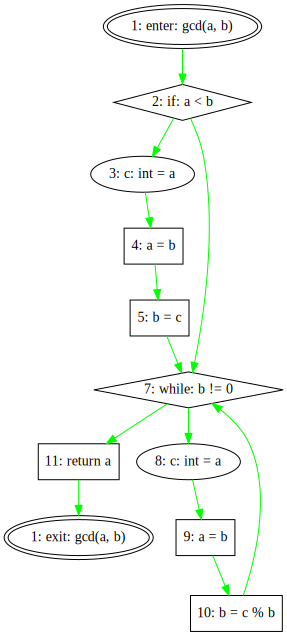

In [167]:
show_cfg(gcd, arcs=cov.arcs())

Indeed both branch and statement coverage visualization seems to indicate that we achieved complete coverage.
How do we make use of our fuzzer in practice? We explore a small case study of a program to solve the roots of a quadratic equation.

#### Example: Roots of a Quadratic Equation
Here is the famous equation for finding the roots of a quadratic equation.

In [168]:
from typing import Tuple

In [169]:
def roots(a: float, b: float, c: float) -> Tuple[float, float]:
    d: float = b * b - 4 * a * c
    ax: float = 0.5 * d
    bx: float = 0
    while (ax - bx) > 0.1:
        bx = 0.5 * (ax + d / ax)
        ax = bx
    s: float = bx

    a2: float = 2 * a
    ba2: float = b / a2
    return -ba2 + s / a2, -ba2 - s / a2

Does the program look correct? Let us investigate if the program is reasonable. But before that, we need a helper
function `sym_to_float()` to convert symbolic values to floating point.

In [170]:
def sym_to_float(v):
    if v is None:
        return math.inf
    elif isinstance(v, z3.IntNumRef):
        return v.as_long()
    return v.numerator_as_long() / v.denominator_as_long()

Now we are ready to fuzz.

In [171]:
asymfz_roots = AdvancedSymbolicFuzzer(
    roots,
    max_tries=10,
    max_iter=10,
    max_depth=10)
with ExpectError():
    for i in range(100):
        r = asymfz_roots.fuzz()
        print(r)
        d = [sym_to_float(r[i]) for i in ['a', 'b', 'c']]
        v = roots(*d)
        print(d, v)

{'a': 1/2, 'b': 1/8, 'c': -2}
[0.5, 0.125, -2.0] (1.87890625, -2.12890625)
{'a': 1/2, 'b': 1/8, 'c': 1}
[0.5, 0.125, 1.0] (-0.125, -0.125)
{'a': 1/2, 'b': 1/8, 'c': -3}
[0.5, 0.125, -3.0] (2.37890625, -2.62890625)
{'a': 1/2, 'b': 1/8, 'c': 2}
[0.5, 0.125, 2.0] (-0.125, -0.125)
{'a': 1/2, 'b': 1/8, 'c': -4}
[0.5, 0.125, -4.0] (2.87890625, -3.12890625)
{'a': 1/2, 'b': 1/8, 'c': 3}
[0.5, 0.125, 3.0] (-0.125, -0.125)
{'a': 0, 'b': 0, 'c': 0}


Traceback (most recent call last):
  File "<ipython-input-171-be5116409d4d>", line 11, in <module>
    v = roots(*d)
  File "<ipython-input-169-f5c00743e7ce>", line 11, in roots
    ba2: float = b / a2
ZeroDivisionError: float division by zero (expected)


We have a `ZeroDivisionError`. Can we eliminate it?

#####  Roots - Check Before Divide

In [172]:
def roots2(a: float, b: float, c: float) -> Tuple[float, float]:
    d: float = b * b - 4 * a * c

    xa: float = 0.5 * d
    xb: float = 0
    while (xa - xb) > 0.1:
        xb = 0.5 * (xa + d / xa)
        xa = xb
    s: float = xb

    if a == 0:
        return -c / b

    a2: float = 2 * a
    ba2: float = b / a2
    return -ba2 + s / a2, -ba2 - s / a2

In [173]:
asymfz_roots = AdvancedSymbolicFuzzer(
    roots2,
    max_tries=10,
    max_iter=10,
    max_depth=10)
with ExpectError():
    for i in range(1000):
        r = asymfz_roots.fuzz()
        d = [sym_to_float(r[i]) for i in ['a', 'b', 'c']]
        v = roots2(*d)
        #print(d, v)

Traceback (most recent call last):
  File "<ipython-input-173-37c0dadab17b>", line 10, in <module>
    v = roots2(*d)
  File "<ipython-input-172-931666e5c85c>", line 12, in roots2
    return -c / b
ZeroDivisionError: float division by zero (expected)


Apparently, our fix was incomplete. Let us try again.

#####  Roots - Eliminating the Zero Division Error

In [174]:
import math

In [175]:
def roots3(a: float, b: float, c: float) -> Tuple[float, float]:
    d: float = b * b - 4 * a * c

    xa: float = 0.5 * d
    xb: float = 0
    while (xa - xb) > 0.1:
        xb = 0.5 * (xa + d / xa)
        xa = xb
    s: float = xb

    if a == 0:
        if b == 0:
            return math.inf
        return -c / b

    a2: float = 2 * a
    ba2: float = b / a2
    return -ba2 + s / a2, -ba2 - s / a2

In [176]:
asymfz_roots = AdvancedSymbolicFuzzer(
    roots3,
    max_tries=10,
    max_iter=10,
    max_depth=10)
for i in range(10):
    r = asymfz_roots.fuzz()
    print(r)
    d = [sym_to_float(r[i]) for i in ['a', 'b', 'c']]
    v = roots3(*d)
    print(d, v)

{'a': -1, 'b': 0, 'c': 0}
[-1.0, 0.0, 0.0] (0.0, 0.0)
{'a': 1, 'b': 1/8, 'c': -2}
[1.0, 0.125, -2.0] (1.439453125, -1.564453125)
{'a': 1, 'b': 1/8, 'c': 1}
[1.0, 0.125, 1.0] (-0.0625, -0.0625)
{'a': 0, 'b': 1/4, 'c': 0}
[0.0, 0.25, 0.0] -0.0
{'a': 0, 'b': 0, 'c': 2}
[0.0, 0.0, 2.0] inf
{'a': 0, 'b': 1, 'c': -1/4}
[0.0, 1.0, -0.25] 0.25
{'a': -1, 'b': 0, 'c': -1}
[-1.0, 0.0, -1.0] (0.0, 0.0)
{'a': 0, 'b': 1/4, 'c': -1}
[0.0, 0.25, -1.0] 4.0
{'a': 0, 'b': 0, 'c': 3}
[0.0, 0.0, 3.0] inf
{'a': 1/2, 'b': 1/8, 'c': -2}
[0.5, 0.125, -2.0] (1.87890625, -2.12890625)


With this, we have demonstrated that we can use our *AdvancedSymbolicFuzzer* to fuzz programs, and it can aid in identifying problems in code.

## Synopsis

This chapter provides an implementation of a symbolic fuzzing engine `AdvancedSymbolicFuzzer`. The fuzzer uses symbolic execution to exhaustively explore paths in the program to a limited depth, and generate inputs that will reach these paths. Given a program to explore (`gcd` here), the fuzzer can be used as follows:

In [177]:
gcd_fuzzer = AdvancedSymbolicFuzzer(gcd, max_tries=10, max_iter=10, max_depth=10)
for i in range(10):
    r = gcd_fuzzer.fuzz()
    print(r)

{'a': 7, 'b': 5}
{'a': -1, 'b': 0}
{'a': 2, 'b': 7}
{'a': 10, 'b': 9}
{'a': 11, 'b': 21}
{'a': 11, 'b': -11}
{'a': 7, 'b': 6}
{'a': -2, 'b': 0}
{'a': 12, 'b': -12}
{'a': 9, 'b': 2}


## Limitations

There is an evident error in this program. We are not checking for negative roots. However, the symbolic execution does not seem to have detected it. Why are we not able to detect the problem of negative roots? Because we stop execution at a predetermined depth without throwing an error. That is, our symbolic execution is wide but shallow. One of the ways this limitation can be overcome is by relying on [concolic execution](ConcolicFuzzer.ipynb), that allows one to go deeper than pure symbolic execution. A second problem is that symbolic execution is necessarily computation intensive. Which means that specification based fuzzers are often able to generate a much larger set of inputs, and consecutively more coverage on programs that do not check for magic bytes, such that they provide a reasonable gradient of exploration.

## Lessons Learned

* One can use symbolic execution to augment the inputs that explore all characteristics of a program.
* Symbolic execution can be broad but shallow.
* Symbolic execution is well suited for programs that rely on specific values to be present in the input, however, its utility decreases when such values are not present, and the input space represents a gradient in terms of coverage.

## Next Steps

* [Search based fuzzing](SearchBasedFuzzer.ipynb) can often be an acceptable middle ground when random fuzzing does not provide sufficient results, but symbolic fuzzing is too heavyweight.

## Background

Symbolic execution of programs was originally described by King \cite{king1976symbolic} in 1976. It is used extensively in vulnerability analysis of software, especially binary programs. Some of the well known symbolic execution tools include KLEE \cite{KLEE}, angr \cite{wang2017angr, stephens2016driller}, and SAGE \cite{godefroid2012sage}. The most well known symbolic execution environment for Python is CHEF \cite{bucur2014prototyping} which does symbolic execution by modifying the interpreter.

The Z3 solver we use in this chapter was developed at Microsoft Research under the lead of Leonardo de Moura and Nikolaj Bjørner \cite{z3}. It is one of the most popular solvers.

## Exercises

### Exercise 1: _Extending Symbolic Fuzzer to use function summaries_

We showed in the first section how function summaries may be produced. Can you extend the `AdvancedSymbolicFuzzer` to use function summaries when needed?

**Solution.** _None yet available._

### Exercise 2: _Statically checking if a loop should be unrolled further_

We examined how loops would be unrolled during exploration to a fixed depth. However, not all loops need to be unrolled completely. Some of the loops may contain only a constant number of iterations. For example, consider the loop below.

In [178]:
i = 0
while i < 10:
    i += 1

This loop needs to be unrolled exactly $10$ times. For such cases, can you implement a method `can_be_satisfied()` which is invoked as below, to only unroll further if the path condition can be satisfied.

In [179]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def get_all_paths(self, fenter):
        path_lst = [PNode(0, fenter)]
        completed = []
        for i in range(self.max_iter):
            new_paths = [PNode(0, fenter)]
            for path in path_lst:
                # explore each path once
                if path.cfgnode.children:
                    np = path.explore()
                    for p in np:
                        if path.idx > self.max_depth:
                            break
                        if self.can_be_satisfied(p):
                            new_paths.append(p)
                        else:
                            break
                else:
                    completed.append(path)
            path_lst = new_paths
        return completed + path_lst

**Solution.** Here is a solution.

In [180]:
class AdvancedSymbolicFuzzer(AdvancedSymbolicFuzzer):
    def can_be_satisfied(self, p):
        s2 = self.extract_constraints(p.get_path_to_root())
        s = z3.Solver()
        identifiers = [c for i in s2 for c in used_identifiers(i)]
        with_types = identifiers_with_types(identifiers, self.used_variables)
        decl = define_symbolic_vars(with_types, '')
        exec(decl)
        exec("s.add(z3.And(%s))" % ','.join(s2), globals(), locals())
        return s.check() == z3.sat

With this implementation, new conditions are appended to paths if and only if the paths are still satisfiable after incorporating the condition.

### Exercise 3: _Implementing a Concolic Fuzzer_


We have seen in the chapter on [concolic fuzzing](ConcolicFuzzer.ipynb) how to trace a function concolicaly using information flow. However, this is somewhat suboptimal as the constraints can get dropped when the information flow is indirect (as in control flow based information flow). Can you implement concolic tracing using the infrastructure we built for symbolic execution?

**Solution.** Here is a possible solution.

In *concolic execution*, we rely on a seed input to guide our symbolic execution. We collect the line numbers that our seed input traces, and feed it to the symbolic execution such that in the `explore` step, only the child node that correspond to the seed input execution path is chosen. This allows us to collect the complete set of constraints along a *representative path*. Once we have it, we can choose any particular predicate and invert it to explore the program execution paths near the representative path.

We modify our original `ArcCoverage` to provide *all* line numbers that the program traversed.

In [181]:
class ArcCoverage(ArcCoverage):
    def offsets_from_entry(self, fn):
        zero = self._trace[0][1] - 1
        return [l - zero for (f, l) in self._trace if f == fn]

In [182]:
with ArcCoverage() as cov:
    roots3(1, 1, 1)

In [183]:
cov.offsets_from_entry('roots3')

[1, 2, 4, 5, 6, 9, 11, 16, 17, 18]

The `ConcolicTracer` first extracts the program trace on a seed input.

In [184]:
class ConcolicTracer(AdvancedSymbolicFuzzer):
    def __init__(self, fn, fnargs, **kwargs):
        with ArcCoverage() as cov:
            fn(*fnargs)
        self.lines = cov.offsets_from_entry(fn.__name__)
        self.current_line = 0
        super().__init__(fn, **kwargs)

The method `get_all_paths()` now tries to follow the seed execution path.

In [185]:
class ConcolicTracer(ConcolicTracer):
    def get_all_paths(self, fenter):
        assert fenter.ast_node.lineno == self.lines[self.current_line]
        self.current_line += 1
        last_node = PNode(0, fenter)
        while last_node and self.current_line < len(self.lines):
            if last_node.cfgnode.children:
                np = last_node.explore()
                for p in np:
                    if self.lines[self.current_line] == p.cfgnode.ast_node.lineno:
                        self.current_line += 1
                        last_node = p
                        break
                else:
                    last_node = None
                    break
            else:
                break
        assert len(self.lines) == self.current_line
        return [last_node]

We are now ready to concolicaly trace our execution.

#### Tracing the Execution Concolicaly

In [186]:
acfz_roots = ConcolicTracer(
    roots3,
    fnargs=[1, 1, 1],
    max_tries=10,
    max_iter=10,
    max_depth=10)

In [187]:
acfz_roots.paths[0].get_path_to_root()

[PNode:0[id:75 line[1] parents: [] : enter: roots3(a, b, c) order:0],
 PNode:1[id:77 line[2] parents: [75] : d: float = b * b - 4 * a * c order:0],
 PNode:2[id:78 line[4] parents: [77] : xa: float = 0.5 * d order:0],
 PNode:3[id:79 line[5] parents: [78] : xb: float = 0 order:0],
 PNode:4[id:80 line[6] parents: [79, 82] : _while: xa - xb > 0.1 order:1],
 PNode:5[id:83 line[9] parents: [80] : s: float = xb order:0],
 PNode:6[id:84 line[11] parents: [83] : _if: a == 0 order:1],
 PNode:7[id:88 line[16] parents: [84] : a2: float = 2 * a order:0],
 PNode:8[id:89 line[17] parents: [88] : ba2: float = b / a2 order:0],
 PNode:9[id:90 line[18] parents: [89] : return -ba2 + s / a2, -ba2 - s / a2 order:0]]

In [188]:
print(cov.offsets_from_entry('roots3'))
print([i.cfgnode.ast_node.lineno for i in acfz_roots.paths[0].get_path_to_root()])
print(acfz_roots.lines)

[1, 2, 4, 5, 6, 9, 11, 16, 17, 18]
[1, 2, 4, 5, 6, 9, 11, 16, 17, 18]
[1, 2, 4, 5, 6, 9, 11, 16, 17, 18]


As can be seen above, we recovered the trace information correctly.
Next, we extract the constraints as usual.

In [189]:
constraints = acfz_roots.extract_constraints(
    acfz_roots.paths[0].get_path_to_root())

In [190]:
constraints

['z3.And(a == _a_0, b == _b_0, c == _c_0)',
 '_d_0 == _b_0 * _b_0 - 4 * _a_0 * _c_0',
 '_xa_0 == 0.5 * _d_0',
 '_xb_0 == 0',
 'z3.Not(_xa_0 - _xb_0 > 0.1)',
 '_s_0 == _xb_0',
 'z3.Not(_a_0 == 0)',
 '_a2_0 == 2 * _a_0',
 '_ba2_0 == _b_0 / _a2_0']

Next, we change our constraints to symbolic variables and solve them.

In [191]:
identifiers = [c for i in constraints for c in used_identifiers(i)]
with_types = identifiers_with_types(identifiers, acfz_roots.used_variables)
decl = define_symbolic_vars(with_types, '')
exec(decl)

We are ready solve our constraints. However, before that, here is a question for you.
*Should it result in exactly the same arguments?*

In [192]:
eval('z3.solve(%s)' % ','.join(constraints))

[_b_0 = 1/8,
 _a_0 = 1,
 _c_0 = 1,
 _ba2_0 = 1/16,
 _a2_0 = 2,
 _s_0 = 0,
 _xb_0 = 0,
 _xa_0 = -255/128,
 _d_0 = -255/64,
 c = 1,
 b = 1/8,
 a = 1]


In [193]:
acfz_roots.fuzz()

{'a': -1, 'b': 0, 'c': 0}

Did they take the same path?

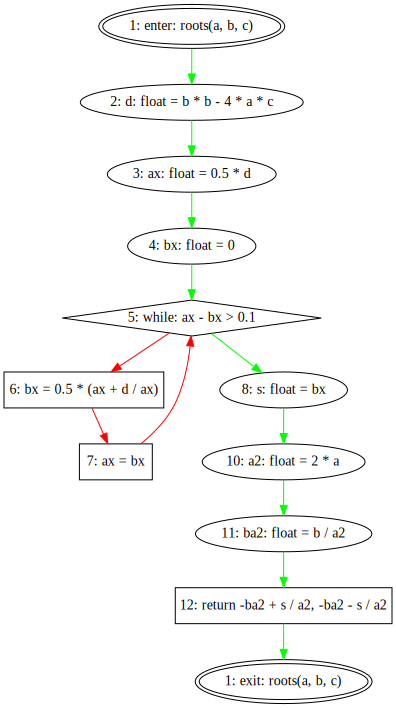

In [194]:
with ArcCoverage() as cov:
    roots(1, 1, 1)
show_cfg(roots, arcs=cov.arcs())

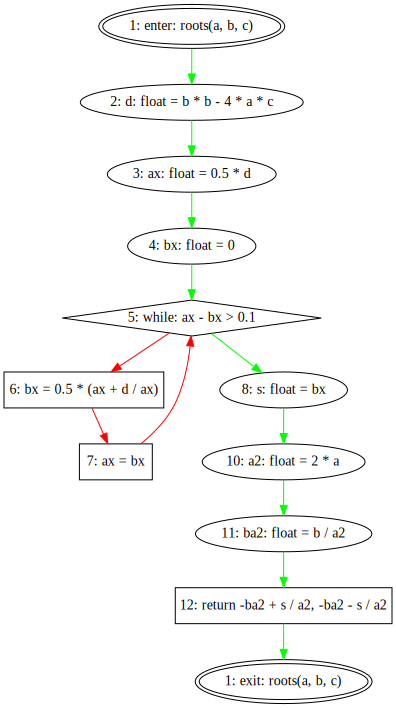

In [195]:
with ArcCoverage() as cov:
    roots(-1, 0, 0)
show_cfg(roots, arcs=cov.arcs())

Indeed, even though the arguments were different, the path traced is exactly the same.

As we saw in the chapter on [concolic fuzzing](ConcolicFuzzer.ipynb), concolic tracing has another use, namely that we can use it to explore nearby paths. We will see how to do that next.

#### Exploring Nearby Paths

We collected the following constraints.

In [196]:
constraints

['z3.And(a == _a_0, b == _b_0, c == _c_0)',
 '_d_0 == _b_0 * _b_0 - 4 * _a_0 * _c_0',
 '_xa_0 == 0.5 * _d_0',
 '_xb_0 == 0',
 'z3.Not(_xa_0 - _xb_0 > 0.1)',
 '_s_0 == _xb_0',
 'z3.Not(_a_0 == 0)',
 '_a2_0 == 2 * _a_0',
 '_ba2_0 == _b_0 / _a2_0']

We can explore nearby paths by negating the conditionals starting from the very last. (A question for the student: Why do we want to start negating from the very last?)

In [197]:
new_constraints = constraints[0:4] + ['z3.Not(%s)' % constraints[4]]

In [198]:
new_constraints

['z3.And(a == _a_0, b == _b_0, c == _c_0)',
 '_d_0 == _b_0 * _b_0 - 4 * _a_0 * _c_0',
 '_xa_0 == 0.5 * _d_0',
 '_xb_0 == 0',
 'z3.Not(z3.Not(_xa_0 - _xb_0 > 0.1))']

In [199]:
eval('z3.solve(%s)' % ','.join(new_constraints))

[_b_0 = 0,
 _c_0 = 1,
 _a_0 = -11/20,
 _xb_0 = 0,
 _xa_0 = 11/10,
 _d_0 = 11/5,
 c = 1,
 b = 0,
 a = -11/20]


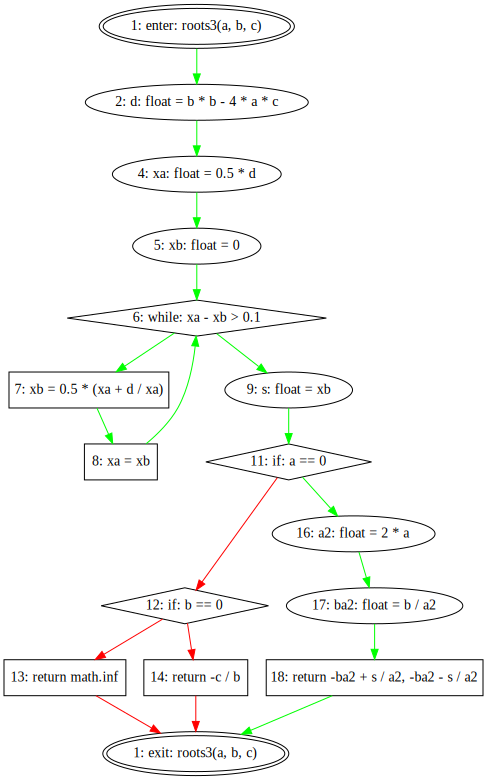

In [200]:
with ArcCoverage() as cov:
    roots3(1, 0, -11 / 20)
show_cfg(roots3, arcs=cov.arcs())

Indeed, the path traced is now different. One can continue this procedure to the necessary number of times to explore all nearby paths to the execution.

Can you incorporate this exploration into the concolic fuzzer?

**Solution.** _None yet available._